In [ ]:
# Mount Google Drive if using Colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
    USING_COLAB = True
except:
    USING_COLAB = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import sys
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
# import warnings
# warnings.filterwarnings('ignore')
from typing import Dict, List, Tuple, Optional, Any

In [ ]:
import joblib
import psutil
import torch
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix,
    classification_report, roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score
)
from datetime import datetime

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from torch.utils.data import Dataset
from torch.nn.parallel import DataParallel

In [ ]:
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    get_linear_schedule_with_warmup
)

In [ ]:
# Configuración de logging
import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('training.log'),
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)

In [ ]:
if USING_COLAB:
    results_dir = "/content/drive/My Drive/GTSI/Codigos_ods/results"
    plots_dir = "/content/drive/My Drive/GTSI/Codigos_ods/plots"
    data_dir = "/content/drive/My Drive/GTSI/Codigos_ods/data"
    models_dir = "/content/drive/My Drive/GTSI/Codigos_ods/models"
else:
    results_dir = "./results"
    plots_dir = "./plots"
    data_dir = "./data"
    models_dir = "./models"

# 1. Análisis del sistema

In [ ]:
def get_system_info():
    """Obtener información del sistema"""
    info = {
        'cpu_count': psutil.cpu_count(),
        'cpu_count_logical': psutil.cpu_count(logical=True),
        'memory_total_gb': psutil.virtual_memory().total / (1024**3),
        'memory_available_gb': psutil.virtual_memory().available / (1024**3),
        'gpu_available': torch.cuda.is_available(),
        'gpu_count': torch.cuda.device_count() if torch.cuda.is_available() else 0,
    }

    if info['gpu_available']:
        gpu_info = []
        for i in range(info['gpu_count']):
            gpu_props = torch.cuda.get_device_properties(i)
            gpu_info.append({
                'name': gpu_props.name,
                'memory_total_gb': gpu_props.total_memory / (1024**3),
                'compute_capability': f"{gpu_props.major}.{gpu_props.minor}"
            })
        info['gpu_details'] = gpu_info

    return info

In [ ]:
def recommend_batch_size(model_name: str = 'roberta-base') -> int:
    """Recomendar tamaño de batch basado en recursos disponibles"""
    if not torch.cuda.is_available():
        return 8  # CPU

    gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)

    # Recomendaciones basadas en memoria GPU
    if gpu_memory >= 24:  # RTX 4090, A100, etc.
        return 32 if 'large' not in model_name else 16
    elif gpu_memory >= 16:  # RTX 4080, V100, etc.
        return 24 if 'large' not in model_name else 12
    elif gpu_memory >= 12:  # RTX 4070 Ti, RTX 3080 Ti, etc.
        return 16 if 'large' not in model_name else 8
    elif gpu_memory >= 8:   # RTX 4060 Ti, RTX 3070, etc.
        return 12 if 'large' not in model_name else 6
    else:  # GPUs más pequeñas
        return 8 if 'large' not in model_name else 4

In [ ]:
"""Imprimir reporte del sistema"""
info = get_system_info()

print("="*60)
print("REPORTE DEL SISTEMA")
print("="*60)
print(f"CPU: {info['cpu_count']} cores físicos, {info['cpu_count_logical']} lógicos")
print(f"RAM: {info['memory_total_gb']:.1f} GB total, {info['memory_available_gb']:.1f} GB disponible")

if info['gpu_available']:
    print(f"\nGPUs disponibles: {info['gpu_count']}")
    for i, gpu in enumerate(info['gpu_details']):
        print(f"  GPU {i}: {gpu['name']}")
        print(f"    Memoria: {gpu['memory_total_gb']:.1f} GB")
        print(f"    Compute Capability: {gpu['compute_capability']}")
else:
    print("\nNo hay GPUs disponibles")

print(f"\nBatch size recomendado: {recommend_batch_size()}")
print("="*60)

REPORTE DEL SISTEMA
CPU: 2 cores físicos, 2 lógicos
RAM: 12.7 GB total, 6.7 GB disponible

GPUs disponibles: 1
  GPU 0: Tesla T4
    Memoria: 14.7 GB
    Compute Capability: 7.5

Batch size recomendado: 16


# 2. Crear directorios en caso de no existir

In [ ]:
directories = [data_dir, models_dir, results_dir, plots_dir]
for dir_path in directories:
    Path(dir_path).mkdir(exist_ok=True)
    print(f"✓ {dir_path}")

✓ /content/drive/My Drive/GTSI/Codigos_ods/data
✓ /content/drive/My Drive/GTSI/Codigos_ods/models
✓ /content/drive/My Drive/GTSI/Codigos_ods/results
✓ /content/drive/My Drive/GTSI/Codigos_ods/plots


# 3. Dataset

In [ ]:
# df = pd.read_csv(data_dir + "/dataset_balansed.csv")
df = pd.read_csv(data_dir + "/dataset_balansed_lema.csv")
print(f"✓ Datos cargados: {len(df)} muestras")
print(f"✓ SDGs únicos: {df['value'].nunique()}") # Sistema de Gestión de Datos
print(f"✓ Distribución por SDG:") # Stochastic Gradient Descent
print(df['value'].value_counts().head())

✓ Datos cargados: 80144 muestras
✓ SDGs únicos: 16
✓ Distribución por SDG:
value
9     5009
12    5009
7     5009
3     5009
13    5009
Name: count, dtype: int64


In [ ]:
df.iloc[0]

,0
CORPUS,Analyse the research lines in Iberoamerica wit...
value,9
lang,es
gpu_used,NaN
text,analyse research line iberoamerica regard desi...


In [ ]:
if "CORPUS" in df.keys():
    print(df.keys())
    df["text_cp"] = df["text"]  # Guarda el contenido original de 'text' en 'text_cp'
    df["text"] = df["CORPUS"]   # Copia el contenido de 'CORPUS' a 'text'
    print("CORPUS copiado a la columna text y text original almacenado en text_cp.")
    print(df.keys())
else:
    print("Solo existe text, se mantiene la columna de text.")

In [ ]:
df.iloc[0]

# 4. Análisis exploratorio

In [ ]:
# Estadísticas básicas
text_lengths = df['text'].str.len()
print(f"✓ Longitud promedio de texto: {text_lengths.mean():.1f} caracteres")
print(f"✓ Longitud mínima: {text_lengths.min()}")
print(f"✓ Longitud máxima: {text_lengths.max()}")

✓ Longitud promedio de texto: 415.8 caracteres
✓ Longitud mínima: 67
✓ Longitud máxima: 868


In [ ]:
info = {
    'total_samples': len(df),
    'unique_labels': df['value'].nunique(),
    'label_distribution': df['value'].value_counts().to_dict(),
    'text_lengths': {
        'mean': df['text'].str.len().mean(),
        'std': df['text'].str.len().std(),
        'min': df['text'].str.len().min(),
        'max': df['text'].str.len().max()
    },
    'missing_values': df.isnull().sum().to_dict()
}

# Guardar información
with open(os.path.join(results_dir, 'data_analysis.json'), 'w') as f:
    json.dump(info, f, indent=2, default=str)


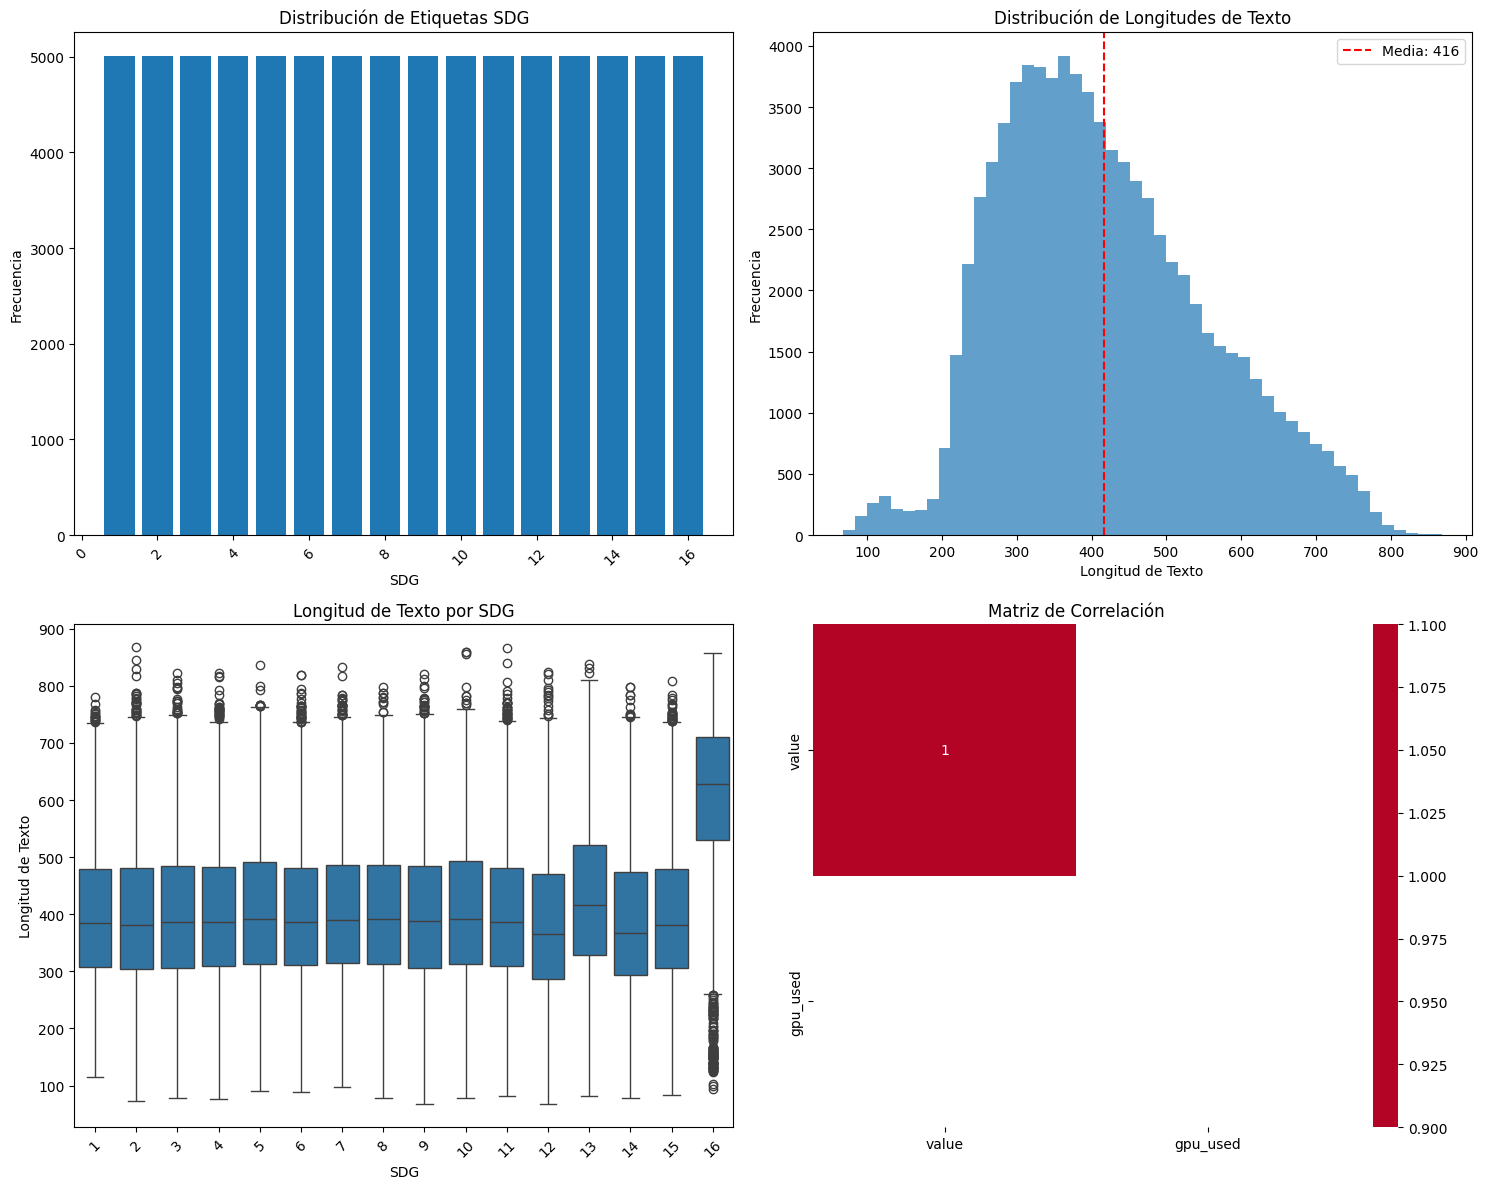

✓ Visualizaciones guardadas en /content/drive/My Drive/GTSI/Codigos_ods/plots/data_analysis.png


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribución de etiquetas
label_counts = pd.Series(info['label_distribution'])
axes[0, 0].bar(label_counts.index, label_counts.values)
axes[0, 0].set_title('Distribución de Etiquetas SDG')
axes[0, 0].set_xlabel('SDG')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].tick_params(axis='x', rotation=45)

# Distribución de longitudes de texto
text_lengths_chars = df['text'].str.len() # cantidad de caracteres
text_lengths_words = df['text'].str.split().str.len() # cantidad de palabras

# axes[0, 1].hist(text_lengths, bins=50, alpha=0.7)
# axes[0, 1].set_title('Distribución de Longitudes de Texto (Caracteres)')
# axes[0, 1].set_xlabel('Longitud de Texto')
# axes[0, 1].set_ylabel('Frecuencia')
# axes[0, 1].axvline(text_lengths.mean(), color='red', linestyle='--', label=f'Media: {text_lengths.mean():.0f}')
# axes[0, 1].axvline(text_lengths.median(), color='green', linestyle='--', label=f'Mediana: {text_lengths.median():.0f}')
# # axes[0, 1].set_xlim(0, text_lengths.max() + 100)
# # axes[0, 1].set_ylim(0, text_lengths.value_counts().max() + 100)
# axes[0, 1].legend()
sns.histplot(text_lengths_chars, bins=50, color='blue', alpha=0.5, label='Caracteres', ax=axes[0, 1])
sns.histplot(text_lengths_words, bins=50, color='orange', alpha=0.5, label='Palabras', ax=axes[0, 1])
axes[0, 1].set_title('Distribución de Longitudes de Texto')
axes[0, 1].set_xlabel('Longitud')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].legend()

# Boxplot de longitudes por SDG
df_plot = df.copy()
df_plot['text_length'] = df_plot['text'].str.len()
sns.boxplot(data=df_plot, x='value', y='text_length', ax=axes[1, 0])
axes[1, 0].set_title('Longitud de Texto por SDG')
axes[1, 0].set_xlabel('SDG')
axes[1, 0].set_ylabel('Longitud de Texto')
axes[1, 0].tick_params(axis='x', rotation=45)

# Heatmap de correlación (si hay más columnas numéricas)
numeric_cols = df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 1:
    corr_matrix = df[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 1])
    axes[1, 1].set_title('Matriz de Correlación')
else:
    axes[1, 1].text(0.5, 0.5, 'No hay suficientes\nvariables numéricas\npara correlación',
                    ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Matriz de Correlación')

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'data_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Visualizaciones guardadas en", os.path.join(plots_dir, 'data_analysis.png'))


In [ ]:
print("Análisis de datos completado.")
print("Cantidad de muestras:", len(df))
print("Cantidad de palabras *********")
print("Minimo:", text_lengths_words.min())
print("Máximo:", text_lengths_words.max())
print("Media:", text_lengths_words.mean())
print("Mediana", text_lengths_words.median())
print("Cantidad de caracteres *********")
print("Minimo:", text_lengths_chars.min())
print("Máximo:", text_lengths_chars.max())
print("Media:", text_lengths_chars.mean())
print("Mediana", text_lengths_chars.median())

# 5. Optimización de configuración

In [ ]:
def optimize_config(base_config):
    """Optimizar configuración basada en recursos disponibles"""
    system_info = get_system_info()
    optimized = base_config.copy()

    # Optimizar batch size
    if system_info['gpu_available']:
        gpu_memory = system_info['gpu_details'][0]['memory_total_gb']
        optimized['batch_size'] = 16 #recommend_batch_size()

        # Ajustar número de workers
        optimized['num_workers'] = min(system_info['cpu_count'], 8)

        # Habilitar optimizaciones GPU
        optimized['fp16'] = True
        optimized['dataloader_pin_memory'] = True

        # Multi-GPU
        if system_info['gpu_count'] > 1:
            optimized['multi_gpu'] = True
            optimized['batch_size'] *= system_info['gpu_count']
    else:
        # Configuración para CPU
        optimized['batch_size'] = 8
        optimized['num_workers'] = system_info['cpu_count']
        optimized['fp16'] = False
        optimized['dataloader_pin_memory'] = False

    # # Ajustar épocas basado en tamaño del dataset
    # if 'dataset_size' in base_config:
    #     if base_config['dataset_size'] < 50000:
    #         optimized['num_epochs'] = 10
    #     elif base_config['dataset_size'] < 100000:
    #         optimized['num_epochs'] = 5
    #     else:
    #         optimized['num_epochs'] = 3

    return optimized

In [ ]:
def get_device():
    """Detecta el mejor dispositivo disponible"""
    if torch.cuda.is_available():
        return f"cuda:{torch.cuda.current_device()}"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

In [ ]:
base_config = {
    'dataset_size': len(df),
    'test_size': 0.2,
    'val_size': 0.2,  # Del conjunto de entrenamiento
    'random_state': 42,
    'warmup_steps': 500,
    'weight_decay': 0.01,
    'early_stopping_patience': 3,

    # Configuración de GPU
    "device": get_device(),
    "use_gpu": torch.cuda.is_available(),
    "multi_gpu": torch.cuda.device_count() > 1,

    # Configuración de modelos tradicionales
    "traditional_use_gpu": False,

    # Configuración de transformers
    "transformer_use_gpu": torch.cuda.is_available(),
    'max_length': 512,
    'batch_size': 16 if torch.cuda.is_available() else 8,
    'num_epochs': 5,
    'learning_rate': 2e-5,

    # Logging
    'use_wandb': False,  # Cambiar a True para usar Weights & Biases
    'save_plots': True,
    'verbose': True,

    "models_to_train": {
        # 'roberta': 'roberta-base',
        'bert': 'bert-base-uncased',
        # 'distilbert': 'distilbert-base-uncased'
    }
}
base_config['num_gpus'] = torch.cuda.device_count() if base_config['use_gpu'] else 0

optimized_config = optimize_config(base_config)
print("Configuración optimizada:")
for key, value in optimized_config.items():
    print(f"  {key}: {value}")

Configuración optimizada:
  dataset_size: 80144
  test_size: 0.2
  val_size: 0.2
  random_state: 42
  warmup_steps: 500
  weight_decay: 0.01
  early_stopping_patience: 3
  device: cuda:0
  use_gpu: True
  multi_gpu: False
  traditional_use_gpu: False
  transformer_use_gpu: True
  max_length: 512
  batch_size: 16
  num_epochs: 5
  learning_rate: 2e-05
  use_wandb: False
  save_plots: True
  verbose: True
  models_to_train: {'bert': 'bert-base-uncased'}
  num_gpus: 1
  num_workers: 2
  fp16: True
  dataloader_pin_memory: True


# 6. Procesamiento

In [ ]:
def clean_data(df):
    """Limpiar y preprocesar datos"""
    print("Limpiando datos...")

    # Eliminar filas con valores nulos
    df['text'] = df['text'].dropna()

    # Convertir texto a string
    df['text'] = df['text'].astype(str)

    # Filtrar textos muy cortos
    df = df[df['text'].str.len() >= 10]

    print(f"Datos después de limpieza: {len(df)} muestras")
    return df

In [ ]:
df = clean_data(df)

Limpiando datos...
Datos después de limpieza: 80144 muestras


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80144 entries, 0 to 80143
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CORPUS    80144 non-null  object 
 1   value     80144 non-null  int64  
 2   lang      42140 non-null  object 
 3   gpu_used  38004 non-null  float64
 4   text      80144 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 3.1+ MB


In [ ]:
def split_data(df):
    """Dividir datos en entrenamiento, validación y prueba"""
    print("Dividiendo datos...")

    # Primera división: train+val vs test
    X = df['text'].values
    y = df['value'].values

    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=base_config["test_size"],
        random_state=base_config["random_state"],
        stratify=y
    )

    # Segunda división: train vs val
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=base_config["val_size"],
        random_state=base_config["random_state"],
        stratify=y_temp
    )

    # Crear DataFrames
    train_df = pd.DataFrame({'text': X_train, 'value': y_train})
    val_df = pd.DataFrame({'text': X_val, 'value': y_val})
    test_df = pd.DataFrame({'text': X_test, 'value': y_test})

    print(f"División de datos - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

    return train_df, val_df, test_df

In [ ]:
train_df, val_df, test_df = split_data(df)

Dividiendo datos...
División de datos - Train: 51292, Val: 12823, Test: 16029


# 7. Entrenamiento

In [ ]:
logger.info("Iniciando pipeline de entrenamiento...")
start_time = time.time()

### Entrenar modelos tradicionales

In [ ]:
def save_traditional_model(model, vectorizer, model_name, results_dict):
    """Guarda modelo tradicional y sus componentes"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_dir = f"{models_dir}/traditional/{model_name}_{timestamp}"
    os.makedirs(model_dir, exist_ok=True)

    # Guardar modelo
    model_path = f"{model_dir}/model.pkl"
    joblib.dump(model, model_path)

    # Guardar vectorizador
    vectorizer_path = f"{model_dir}/vectorizer.pkl"
    joblib.dump(vectorizer, vectorizer_path)

    # Guardar metadatos
    metadata = {
        'model_name': model_name,
        'timestamp': timestamp,
        'val_accuracy': results_dict['val_accuracy'],
        'test_accuracy': results_dict['test_accuracy'],
        'val_f1': results_dict['val_f1'],
        'test_f1': results_dict['f1_score'],
        'gpu_used': results_dict['gpu_used'],
        'model_path': model_path,
        'vectorizer_path': vectorizer_path
    }

    metadata_path = f"{model_dir}/metadata.json"
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)

    print(f"💾 Modelo guardado en: {model_dir}")
    return model_dir


In [ ]:
def train_traditional_models(train_df, val_df, test_df, use_gpu=None, save_models=True):
    """Entrenar modelos tradicionales de ML"""
    logger.info("Entrenando modelos tradicionales...")

    # Configuración de GPU
    if use_gpu is None:
        use_gpu_final = optimized_config["traditional_use_gpu"]
    else:
        use_gpu_final = use_gpu and optimized_config["use_gpu"]

    print(f"   - Configuración GPU: {use_gpu_final}")
    print(f"   - Guardar modelos: {save_models}")

    # Vectorización TF-IDF
    vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
    X_train_tfidf = vectorizer.fit_transform(train_df['text'])
    X_val_tfidf = vectorizer.transform(val_df['text'])
    X_test_tfidf = vectorizer.transform(test_df['text'])

    # Modelos a entrenar
    models = {
        'SVM': SVC(kernel='rbf', probability=True, random_state=base_config["random_state"]),
        'Logistic_Regression': LogisticRegression(random_state=base_config["random_state"], max_iter=1000),
        'Random_Forest': RandomForestClassifier(n_estimators=100, random_state=base_config["random_state"])
    }

    results = {}
    saved_models = {}

    for name, model in models.items():
        print(f"Entrenando {name}...")
        start_time = time.time()

        # Entrenar modelo
        model.fit(X_train_tfidf, train_df['value'])

        # Predicciones
        train_pred = model.predict(X_train_tfidf)
        val_pred = model.predict(X_val_tfidf)
        test_pred = model.predict(X_test_tfidf)

        # Métricas
        results[name] = {
            'train_accuracy': accuracy_score(train_df['value'], train_pred),
            'val_accuracy': accuracy_score(val_df['value'], val_pred),
            'test_accuracy': accuracy_score(test_df['value'], test_pred),
            'training_time': time.time() - start_time,
            'model': model,
            'predictions': {
                'train': train_pred,
                'val': val_pred,
                'test': test_pred
            },
            'gpu_used': use_gpu_final
        }

        val_f1 = f1_score(val_df['value'], val_pred, average='weighted')

        # Métricas detalladas
        precision, recall, f1, _ = precision_recall_fscore_support(
            test_df['value'], test_pred, average='weighted'
        )
        results[name].update({
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'val_f1': val_f1,
        })

        if save_models:
            model_dir = save_traditional_model(model, vectorizer, name, results[name])
            saved_models[name] = model_dir

        logger.info(f"{name} - Test Accuracy: {results[name]['test_accuracy']:.4f}")

    # Guardar vectorizador
    joblib.dump(vectorizer, os.path.join(models_dir, 'tfidf_vectorizer.pkl'))

    return results, saved_models if save_models else {}


In [ ]:
# traditional_results, traditional_saved = train_traditional_models(train_df, val_df, test_df, use_gpu=True)

### Entrenar modelos transformer

In [ ]:
class SDGDataset(Dataset):
    """Dataset personalizado para clasificación de SDG"""

    def __init__(self, texts: List[str], labels: List[int], tokenizer, max_length: int = 512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
def save_transformer_model(model, tokenizer, trainer, model_name, results_dict):
    """Guarda modelo transformer y sus componentes"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_dir = f"{models_dir}/transformers/{model_name.replace('/', '_')}_{timestamp}"
    os.makedirs(model_dir, exist_ok=True)

    # Guardar modelo y tokenizer usando transformers
    if hasattr(model, 'module'):  # Si es DataParallel
        model.module.save_pretrained(model_dir)
    else:
        model.save_pretrained(model_dir)

    tokenizer.save_pretrained(model_dir)

    # Guardar trainer state
    trainer_dir = f"{model_dir}/trainer"
    trainer.save_model(trainer_dir)

    # Guardar metadatos
    metadata = {
        'model_name': model_name,
        'timestamp': timestamp,
        'val_accuracy': results_dict['val_accuracy'],
        'test_accuracy': results_dict['test_accuracy'],
        'val_f1': results_dict['val_f1'],
        'test_f1': results_dict['test_f1'],
        'gpu_used': results_dict['gpu_used'],
        'multi_gpu_used': results_dict['multi_gpu_used'],
        'device': results_dict['device'],
        'model_dir': model_dir,
        'trainer_dir': trainer_dir
    }

    metadata_path = f"{model_dir}/metadata.json"
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)

    print(f"     💾 Modelo transformer guardado en: {model_dir}")
    return model_dir

In [ ]:
def train_transformer_model(model_name: str, train_df: pd.DataFrame,
                              val_df: pd.DataFrame, test_df: pd.DataFrame,
                              use_gpu=None, multi_gpu=None, save_model=True) -> Dict[str, Any]:
        """Entrenar modelo transformer"""
        logger.info(f"Entrenando modelo {model_name}...")

        # Configuración de GPU
        if use_gpu is None:
            use_gpu_final = optimized_config["transformer_use_gpu"]
        else:
            use_gpu_final = use_gpu and optimized_config["use_gpu"]

        if multi_gpu is None:
            multi_gpu_final = optimized_config["multi_gpu"] and use_gpu_final
        else:
            multi_gpu_final = multi_gpu and optimized_config["multi_gpu"] and use_gpu_final

        # Configurar dispositivo
        if use_gpu_final:
            device = optimized_config["device"]
            print(f"   - Usando GPU: {device}")
            if multi_gpu_final:
                print(f"   - Multi-GPU activado: {torch.cuda.device_count()} GPUs")
        else:
            device = "cpu"
            print("   - Usando CPU")

        print(f"   - Guardar modelo: {save_model}")

        # Preparar etiquetas
        label_encoder = LabelEncoder()
        all_labels = pd.concat([train_df['value'], val_df['value'], test_df['value']])
        label_encoder.fit(all_labels)

        train_labels = label_encoder.transform(train_df['value'])
        val_labels = label_encoder.transform(val_df['value'])
        test_labels = label_encoder.transform(test_df['value'])

        # Tokenizer y modelo
        tokenizer = AutoTokenizer.from_pretrained(optimized_config["models_to_train"][model_name])
        model = AutoModelForSequenceClassification.from_pretrained(
            optimized_config["models_to_train"][model_name],
            num_labels=len(label_encoder.classes_),
            ignore_mismatched_sizes=True
        )

        # Mover a GPU si está disponible
        if use_gpu_final:
            model = model.to(device)

            # Configurar multi-GPU si está disponible
            if multi_gpu_final:
                model = DataParallel(model)

        # Crear datasets
        train_dataset = SDGDataset(
            train_df['text'].tolist(), train_labels.tolist(),
            tokenizer, optimized_config["max_length"]
        )
        val_dataset = SDGDataset(
            val_df['text'].tolist(), val_labels.tolist(),
            tokenizer, optimized_config["max_length"]
        )
        test_dataset = SDGDataset(
            test_df['text'].tolist(), test_labels.tolist(),
            tokenizer, optimized_config["max_length"]
        )

        print("epoca", optimized_config["num_epochs"], "batch_size", optimized_config["batch_size"])

        # Configurar entrenamiento
        training_args = TrainingArguments(
            output_dir=os.path.join(models_dir, f'{model_name}_checkpoints'),
            num_train_epochs=optimized_config["num_epochs"],
            per_device_train_batch_size=optimized_config["batch_size"],
            per_device_eval_batch_size=optimized_config["batch_size"],
            warmup_steps=optimized_config["warmup_steps"],
            weight_decay=optimized_config["weight_decay"],
            logging_dir=os.path.join(results_dir, f'{model_name}_logs'),
            logging_steps=10,
            eval_strategy="epoch",
            eval_steps=500,
            save_strategy="epoch",
            save_steps=500,
            load_best_model_at_end=True,
            metric_for_best_model="eval_accuracy",
            greater_is_better=True,
            dataloader_num_workers=(4 if multi_gpu_final else 2) if use_gpu_final else 0,
            fp16=use_gpu_final,  # Usar precisión mixta si hay GPU

            report_to="none",           # Desactivar wandb
            run_name="sdg_classifier",
        )

        # Función de métricas
        def compute_metrics(eval_pred):
            predictions, labels = eval_pred
            predictions = np.argmax(predictions, axis=1)

            accuracy = accuracy_score(labels, predictions)
            precision, recall, f1, _ = precision_recall_fscore_support(
                labels, predictions, average='weighted'
            )

            return {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1
            }

        # Trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=optimized_config["early_stopping_patience"])]
        )

        # Entrenar
        start_time = time.time()
        trainer.train()
        training_time = time.time() - start_time

        # Evaluación
        train_results = trainer.evaluate(train_dataset)
        val_results = trainer.evaluate(val_dataset)
        test_results = trainer.evaluate(test_dataset)

        # Predicciones en validación
        val_predictions = trainer.predict(val_dataset)
        val_preds = np.argmax(val_predictions.predictions, axis=1)

        # Predicciones detalladas
        test_predictions = trainer.predict(test_dataset)
        test_pred_labels = np.argmax(test_predictions.predictions, axis=1)

        # Guardar modelo
        model_save_path = os.path.join(models_dir, f'{model_name}_final')
        trainer.save_model(model_save_path)
        tokenizer.save_pretrained(model_save_path)

        # Guardar label encoder
        joblib.dump(label_encoder, os.path.join(model_save_path, 'label_encoder.pkl'))

        results = {
            'model': model,
            'tokenizer': tokenizer,
            'trainer': trainer,
            'train_accuracy': train_results['eval_accuracy'],
            'val_accuracy': val_results['eval_accuracy'],
            'test_accuracy': test_results['eval_accuracy'],
            'train_f1': train_results['eval_f1'],
            'val_f1': val_results['eval_f1'],
            'test_f1': test_results['eval_f1'],
            'training_time': training_time,
            'model_path': model_save_path,
            'true_labels': test_labels,
            'label_encoder': label_encoder,
            'val_predictions': val_preds,
            'test_predictions': test_pred_labels,
            'gpu_used': use_gpu_final,
            'multi_gpu_used': multi_gpu_final,
            'device': device
        }

        # Guardar modelo si se solicita
        saved_model_dir = None
        if save_model:
            saved_model_dir = save_transformer_model(model, tokenizer, trainer, model_name, results)

        print(f"✓ Val Accuracy: {val_results['eval_accuracy']:.4f}, Test Accuracy: {test_results['eval_accuracy']:.4f}")

        return results, saved_model_dir

In [ ]:
transformer_results = {}
for model_name in base_config["models_to_train"].keys():
    try:
        results, transformer_saved = train_transformer_model(model_name, train_df, val_df, test_df, use_gpu=True)
        transformer_results[model_name] = results
    except Exception as e:
        print(f"Error entrenando {model_name}: {str(e)}")
        continue

   - Usando GPU: cuda:0
   - Guardar modelo: True


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoca 5 batch_size 16


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.635700,0.769294,0.779069,0.780037,0.779069,0.777118
2,0.628200,0.604391,0.831787,0.834218,0.831787,0.831774
3,0.415100,0.550810,0.861655,0.864495,0.861655,0.861541
4,0.082700,0.617299,0.876238,0.878018,0.876238,0.876263
5,0.124800,0.631350,0.886688,0.887091,0.886688,0.886792


     💾 Modelo transformer guardado en: /content/drive/My Drive/GTSI/Codigos_ods/models/transformers/bert_20250615_181621
✓ Val Accuracy: 0.8867, Test Accuracy: 0.8875


# 8. Análisis de resultados

In [ ]:
# Combinar resultados
all_results = {**transformer_results}#{**traditional_results, **transformer_results}

In [ ]:
def create_comparison_plots(summary: Dict[str, Any], all_results: Dict[str, Any], test_df: pd.DataFrame):
    """Crear gráficos comparativos"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    models = list(summary.keys())
    accuracies = [summary[m]['test_accuracy'] for m in models]
    f1_scores = [summary[m]['test_f1'] for m in models]
    times = [summary[m]['training_time'] for m in models]

    # Comparación de accuracy
    bars1 = axes[0, 0].bar(models, accuracies, color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Comparación de Accuracy en Test')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Añadir valores en las barras
    for bar, acc in zip(bars1, accuracies):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{acc:.3f}', ha='center', va='bottom')

    # Comparación de F1-Score
    bars2 = axes[0, 1].bar(models, f1_scores, color='lightcoral', alpha=0.7)
    axes[0, 1].set_title('Comparación de F1-Score en Test')
    axes[0, 1].set_ylabel('F1-Score')
    axes[0, 1].tick_params(axis='x', rotation=45)

    for bar, f1 in zip(bars2, f1_scores):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{f1:.3f}', ha='center', va='bottom')

    # Tiempo de entrenamiento
    bars3 = axes[1, 0].bar(models, times, color='lightgreen', alpha=0.7)
    axes[1, 0].set_title('Tiempo de Entrenamiento')
    axes[1, 0].set_ylabel('Tiempo (segundos)')
    axes[1, 0].tick_params(axis='x', rotation=45)

    for bar, time_val in zip(bars3, times):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(times)*0.01,
                        f'{time_val:.1f}s', ha='center', va='bottom')

    # Scatter plot: Accuracy vs Tiempo
    axes[1, 1].scatter(times, accuracies, s=100, alpha=0.7)
    for i, model in enumerate(models):
        axes[1, 1].annotate(model, (times[i], accuracies[i]),
                            xytext=(5, 5), textcoords='offset points')
    axes[1, 1].set_xlabel('Tiempo de Entrenamiento (s)')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].set_title('Accuracy vs Tiempo de Entrenamiento')

    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, 'model_comparison.png'),
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
def create_confusion_matrix_analysis(best_model_name: str, best_results: Dict[str, Any], test_df: pd.DataFrame):
    """Crear análisis de matriz de confusión para el mejor modelo"""
    if 'predictions' not in best_results:
        return

    # Extraer etiquetas verdaderas
    if 'label' in test_df.columns:
        true_labels = test_df['label'].values
    elif 'value' in test_df.columns:
        true_labels = test_df['value'].values
    else:
        print("❌ No se encontró columna de etiquetas")
        return

    # Extraer predicciones (buscar en múltiples claves)
    predictions = None
    possible_keys = ['test_predictions', 'predictions', 'y_pred', 'test_pred']

    for key in possible_keys:
        if key in best_results and best_results[key] is not None:
            predictions = best_results[key]
            break

    if predictions is None:
        print(f"❌ No se encontraron predicciones. Claves disponibles: {list(best_results.keys())}")
        return

    # Verificar tamaños
    print(f"📊 Etiquetas: {len(true_labels)}, Predicciones: {len(predictions)}")

    if len(true_labels) != len(predictions):
        min_size = min(len(true_labels), len(predictions))
        true_labels = true_labels[:min_size]
        predictions = predictions[:min_size]
        print(f"🔧 Ajustado a {min_size} muestras")

    # Matriz de confusión
    cm = confusion_matrix(true_labels, predictions)

    # Crear visualización
    plt.figure(figsize=(12, 10))

    # Obtener nombres de clases
    if 'label_encoder' in best_results:
        class_names = best_results['label_encoder'].classes_
    else:
        class_names = sorted(set(true_labels))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusión - {best_model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, f'confusion_matrix_{best_model_name}.png'),
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # Reporte de clasificación
    report = classification_report(true_labels, predictions,
                                    target_names=[str(c) for c in class_names],
                                    output_dict=True)

    with open(os.path.join(results_dir, f'classification_report_{best_model_name}.json'), 'w') as f:
        json.dump(report, f, indent=2)

In [ ]:
def create_detailed_analysis(all_results: Dict[str, Any], test_df: pd.DataFrame):
    """Crear análisis detallado de resultados"""
    logger.info("Creando análisis detallado de resultados...")

    # Resumen de resultados
    summary = {}
    for model_name, results in all_results.items():
        summary[model_name] = {
            'test_accuracy': results.get('test_accuracy', 0),
            'test_f1': results.get('f1_score', results.get('test_f1', 0)),
            'training_time': results.get('training_time', 0)
        }

    # Crear visualizaciones comparativas
    create_comparison_plots(summary, all_results, test_df)

    # Análisis de confusión para el mejor modelo
    best_model = max(summary.keys(), key=lambda x: summary[x]['test_accuracy'])
    # COMENTADO ****************************************************************************
    # create_confusion_matrix_analysis(best_model, all_results[best_model], test_df)

    # Guardar resumen
    with open(os.path.join(results_dir, 'results_summary.json'), 'w') as f:
        json.dump(summary, f, indent=2, default=str)

    return summary

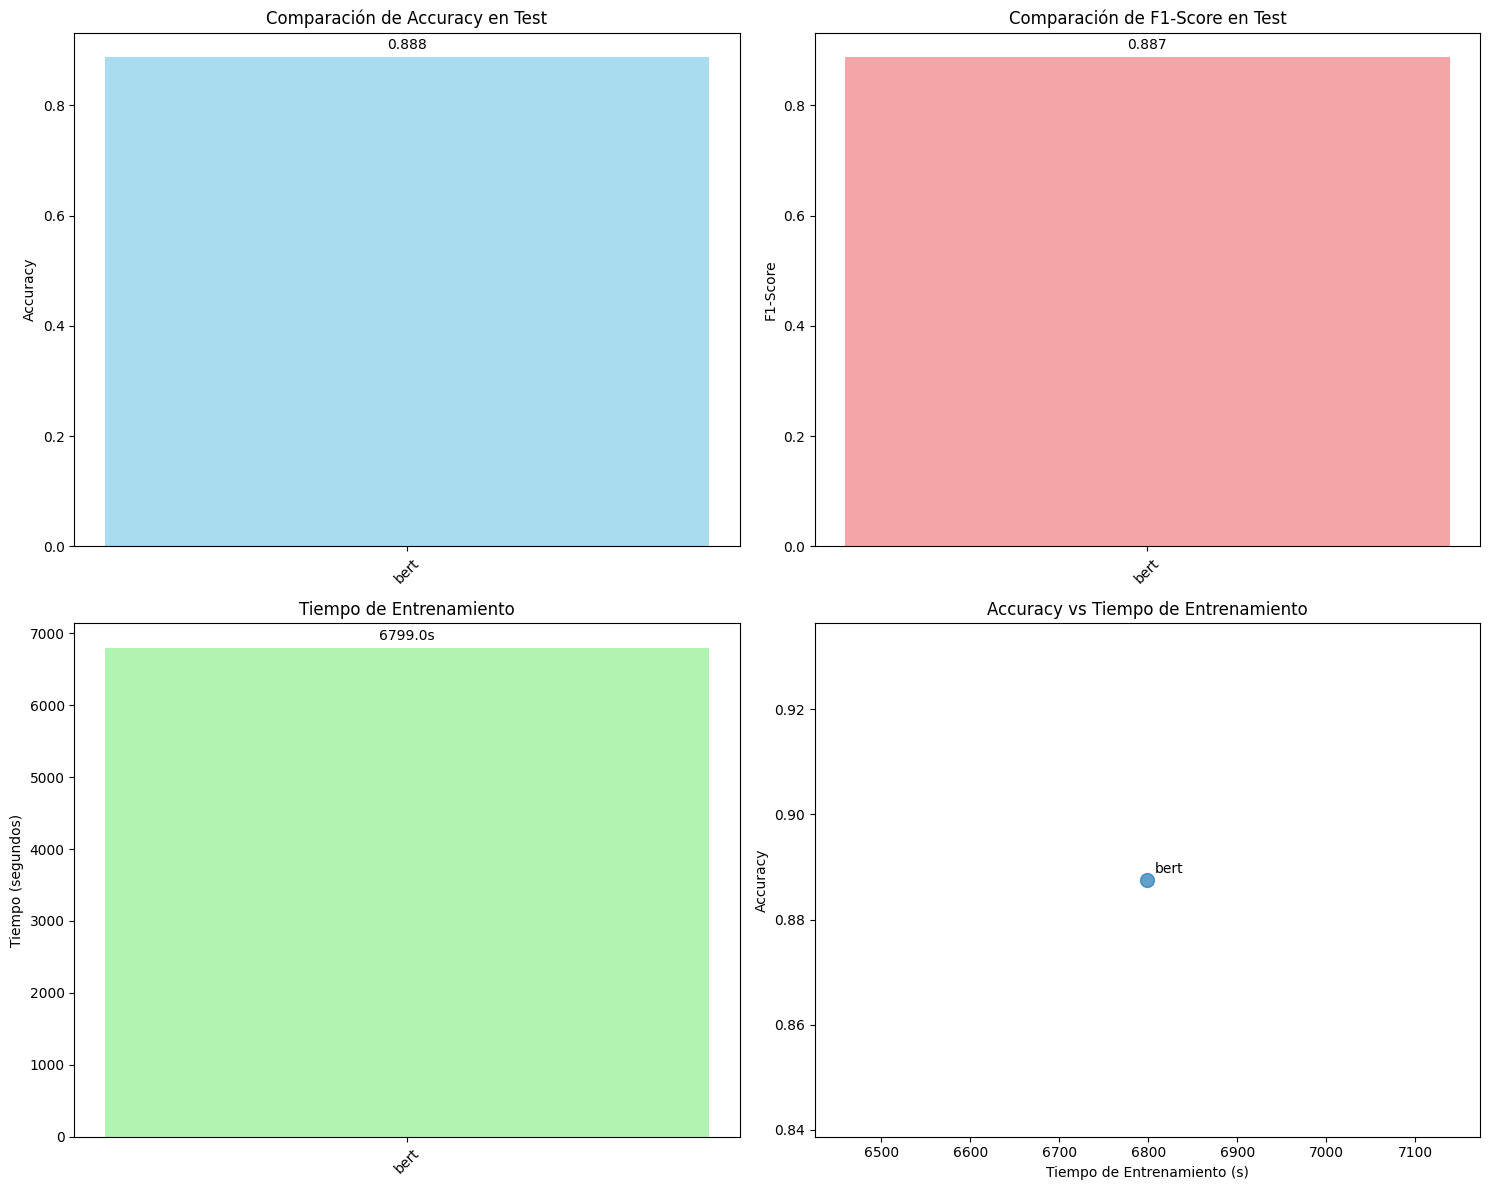

In [ ]:
summary = create_detailed_analysis(all_results, test_df)

# 9. Reporte final

In [ ]:
# Tiempo total
total_time = time.time() - start_time
logger.info(f"Entrenamiento completado en {total_time:.2f} segundos")

# Mostrar mejores resultados
# el accuracy mas grande y da como resultado el key
best_model = max(summary.keys(), key=lambda x: summary[x]['test_accuracy'])
logger.info(f"Mejor modelo: {best_model} con accuracy: {summary[best_model]['test_accuracy']:.4f}")

In [ ]:
print("\n" + "="*50)
print("RESUMEN DE RESULTADOS")
print("="*50)
for model_name, metrics in summary.items():
    print(f"{model_name}:")
    print(f"  - Test Accuracy: {metrics['test_accuracy']:.4f}")
    print(f"  - Test F1-Score: {metrics['test_f1']:.4f}")
    print(f"  - Tiempo de entrenamiento: {metrics['training_time']:.2f}s")
    print()


RESUMEN DE RESULTADOS
bert:
  - Test Accuracy: 0.8875
  - Test F1-Score: 0.8875
  - Tiempo de entrenamiento: 6798.96s

